In [1]:
from __future__ import annotations

%load_ext jupyter_black

In [2]:
import os
from typing import Any

import numpy as np
import xarray as xr

from mesoscaler.core import Mesoscale, P0, DependentDataset
from mesoscaler.enums import (
    # - independent variables
    Dimensions,
    Coordinates,
    # - dependent variables
    ERA5,
    GEOPOTENTIAL,
    SPECIFIC_HUMIDITY,
    TEMPERATURE,
    U_COMPONENT_OF_WIND,
    V_COMPONENT_OF_WIND,
    URMA,
    SURFACE_PRESSURE,
    TEMPERATURE_2M,
    SPECIFIC_HUMIDITY_2M,
    U_WIND_COMPONENT_10M,
    V_WIND_COMPONENT_10M,
    SURFACE_PRESSURE,
)

_test_data = "../tests/data"

urma_store = os.path.join(_test_data, "urma.zarr")
era5_store = os.path.join(_test_data, "era5.zarr")

print("\n".join(f"{t.__name__} = {tuple(t)}" for t in (Dimensions, Coordinates, URMA, ERA5)))

Dimensions = (T, Z, Y, X)
Coordinates = (time, vertical, latitude, longitude)
URMA = (total_cloud_cover, ceiling, u_wind_component_10m, v_wind_component_10m, wind_speed_10m, wind_speed_gust, wind_direction_10m, temperature_2m, dewpoint_temperature_2m, specific_humidity_2m, surface_pressure, visibility, orography)
ERA5 = (geopotential, specific_humidity, temperature, u_component_of_wind, v_component_of_wind, vertical_velocity)


In [3]:
URMA_GRID_RESOLUTION = 2.5  # km
ERA5_GRID_RESOLUTION = 30.0  # km (0.25 deg)
DX = 200  # km
DY = 175  # km
D = DX, DY = np.array([200, 175])
pressure_levels = [P0, 1000.0, 925.0, 850.0, 700.0, 500.0, 300.0]
scale = Mesoscale(DX, DY, levels=pressure_levels, rate=15)

extent = scale.to_numpy(units="km")
extent[0] /= URMA_GRID_RESOLUTION
extent[1:] /= ERA5_GRID_RESOLUTION

print(scale, extent, sep="\n")
print(
    (URMA_GRID_RESOLUTION / scale.dx[1:]),
    sep="\n",
)

sx = scale.scale.copy()
sx[0] *= URMA_GRID_RESOLUTION
sx[1:] *= ERA5_GRID_RESOLUTION
sy = scale.scale.copy()
sy[0] *= URMA_GRID_RESOLUTION
sy[1:] *= ERA5_GRID_RESOLUTION
print(np.c_[sx, sy], sep="\n")

(scale.dx[1:] / 30) / 80

Mesoscale(size=7):
-       scale: [ 1.00  3.81  7.52  9.43 11.69 13.52 14.78]
- levels[hPa]: [1013.25 1000.00  925.00  850.00  700.00  500.00  300.00]
-  extent[km]: 
[[ -200.00  -175.00   200.00   175.00]
 [ -761.70  -666.49   761.70   666.49]
 [-1504.23 -1316.20  1504.23  1316.20]
 [-1885.10 -1649.47  1885.10  1649.47]
 [-2338.60 -2046.27  2338.60  2046.27]
 [-2704.87 -2366.76  2704.87  2366.76]
 [-2956.21 -2586.68  2956.21  2586.68]]
[[-80.         -70.          80.          70.        ]
 [-25.39003874 -22.2162839   25.39003874  22.2162839 ]
 [-50.14099032 -43.87336653  50.14099032  43.87336653]
 [-62.83678289 -54.98218503  62.83678289  54.98218503]
 [-77.9531895  -68.20904081  77.9531895   68.20904081]
 [-90.16226411 -78.89198109  90.16226411  78.89198109]
 [-98.54020502 -86.22267939  98.54020502  86.22267939]]
[0.00328213 0.00166198 0.00132619 0.00106902 0.00092426 0.00084568]
[[  2.5          2.5       ]
 [114.25517434 114.25517434]
 [225.63445644 225.63445644]
 [282.76552302 282

array([0.31737548, 0.62676238, 0.78545979, 0.97441487, 1.1270283 ,
       1.23175256])

In [4]:
dict(scale.data)

{'scale': array([ 1.        ,  3.80850581,  7.52114855,  9.42551743, 11.69297842,
        13.52433962, 14.78103075]),
 'levels': array([1013.25, 1000.  ,  925.  ,  850.  ,  700.  ,  500.  ,  300.  ]),
 'area_extent': array([[ -200.        ,  -175.        ,   200.        ,   175.        ],
        [ -761.70116227,  -666.48851699,   761.70116227,   666.48851699],
        [-1504.22970961, -1316.2009959 ,  1504.22970961,  1316.2009959 ],
        [-1885.10348681, -1649.46555096,  1885.10348681,  1649.46555096],
        [-2338.59568489, -2046.27122428,  2338.59568489,  2046.27122428],
        [-2704.86792325, -2366.75943284,  2704.86792325,  2366.75943284],
        [-2956.20615068, -2586.68038185,  2956.20615068,  2586.68038185]])}

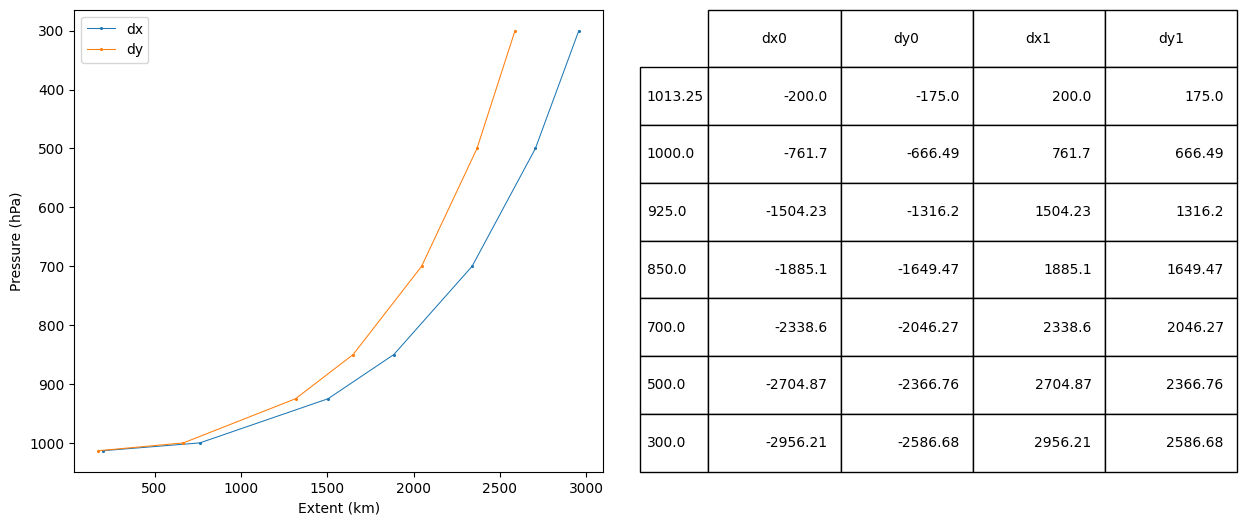

In [5]:
import matplotlib.pyplot as plt

X1, X2, Y = scale.dx, scale.dy, scale.levels
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(121)
ax.invert_yaxis()
ax.plot(X1, Y, linestyle="-", linewidth=0.75, marker=".", markersize=2.5)
ax.plot(X2, Y, linestyle="-", linewidth=0.75, marker=".", markersize=2.5)
ax.set_ylabel("Pressure (hPa)")
ax.set_xlabel("Extent (km)")
ax.legend(["dx", "dy"])

ax2 = fig.add_subplot(122)
import pandas as pd

df = pd.DataFrame(np.asarray(scale), index=scale.levels, columns=["dx0", "dy0", "dx1", "dy1"])

ax2.axis("off")
mpl_table = ax2.table(
    cellText=df.to_numpy().round(2).astype(str).tolist(),
    rowLabels=df.index.tolist(),
    bbox=[0, 0, 1, 1],  # type: ignore
    colLabels=df.columns.tolist(),
)

In [6]:
# define the variables and levels

era5_dvars = [
    GEOPOTENTIAL,
    SPECIFIC_HUMIDITY,
    TEMPERATURE,
    U_COMPONENT_OF_WIND,
    V_COMPONENT_OF_WIND,
]
urma_dvars = [
    SURFACE_PRESSURE,
    TEMPERATURE_2M,
    SPECIFIC_HUMIDITY_2M,
    U_WIND_COMPONENT_10M,
    V_WIND_COMPONENT_10M,
]
assert len(era5_dvars) == len(urma_dvars), "vard must be the same length in order to be resampled"

era5 = DependentDataset.from_zarr(era5_store, era5_dvars)  # get datasets
urma = DependentDataset.from_zarr(urma_store, urma_dvars)  # get datasets

In [7]:
print(
    era5.to_array().shape,
    urma.to_array().shape,
    scale.levels.shape,
    sep="\n",
)

(5, 2, 37, 721, 1440)
(5, 2, 1, 1597, 2345)
(7,)


In [8]:
a = np.stack([era5[dvar].to_numpy() for dvar in era5.data_vars])
a.shape  # (Variable, Time, Level, Latitude, Longitude)

(5, 2, 37, 721, 1440)

In [9]:
time = era5.time.to_numpy()
start, stop = time

In [10]:
# scott afb
from mesoscaler.utils import join_kv

longitude = -89.835
latitude = 38.54

sampler = scale.resample([urma, era5], height=70, width=80)
arr = sampler.__call__(longitude, latitude, time=time)


print(
    join_kv(
        "Shapes:",
        ("dimensions", ("V",) + tuple(Dimensions)),
        ("urma", urma.to_array().shape),
        ("era5", era5.to_array().shape),
        ("resampled", arr.shape),
    )
)

Shapes:
- dimensions: (V, T, Z, Y, X)
-       urma: (5, 2, 1, 1597, 2345)
-       era5: (5, 2, 37, 721, 1440)
-  resampled: (5, 2, 7, 70, 80)


In [11]:
(
    xr.DataArray(
        arr,
        dims=["dvars", Dimensions.T, Dimensions.Z, Dimensions.Y, Dimensions.X],
        coords={
            # "dvars": era5_dvars,
            # Coordinates.vertical: (Coordinates.vertical.axis, scale.levels),
            # Coordinates.time: (Coordinates.time.axis, time),
        },
    )
)

<xarray.DataArray (dvars: 5, T: 2, Z: 7, Y: 70, X: 80)>
array([[[[[            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          ...,
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan]],

         [[ 2.04577332e+03,  2.01178027e+03,  2.01617798e+03, ...,
            1.95472913e+03,  1.94605261e+03,  1.92525269e+03],
          [ 2.04577332e+03,  2.05112183e+03,  2.05219165e+03, ...,
            1.95175769e+03,  1.94248682e+03,  1.92525269e+03],
          [ 2.09165186e+03,  2.09224634e+03,  2.05896631e+03, ...,
            1.95175769e+03,  1.92335095e+03,  1.90825610e+03],
...
           -1.17755566e+01, -1.28712149e+01, -1.37593622e+01],
          [-2.56538820e+00, -3.08499575e+00, -2.76293850e+00, ...,
           -1.11663046e+01, -1.22686033e+01, -1.30206232e+01],
          [-4.67203999e+00, -5.10532284e+00, -4.18895435e+00, ...,
           -1.07695436e+01, -1.18818026e+01, -1.27052059e+01]],

         [[ 2.12982693e+01,  2.36154099e+01,  2.74626503e+01, ...,
            3.73724213e+01,  3.97404861e+01,  3.60714874e+01],
          [ 2.33769836e+01,  2.75668163e+01,  3.21848946e+01, ...,
            3.46270370e+01,  4.47543983e+01,  4.08377151e+01],
          [ 2.85783958e+01,  3.28029556e+01,  3.74812164e+01, ...,
            2.85089512e+01,  4.78886719e+01,  4.61687584e+01],
          ...,
          [ 3.38261070e+01,  3.27265663e+01,  3.14024830e+01, ...,
           -9.47270679e+00, -1.11509552e+01, -1.25838318e+01],
          [ 3.17010956e+01,  3.13608170e+01,  2.88492298e+01, ...,
           -1.05768785e+01, -1.16717911e+01, -1.28500366e+01],
          [ 2.99649754e+01,  3.11339626e+01,  3.00784035e+01, ...,
           -1.03222475e+01, -1.14125299e+01, -1.24588318e+01]]]]],
      dtype=float32)
Dimensions without coordinates: dvars, T, Z, Y, X

In [12]:
def locate(dvar: Any, level: float, time: int = 0) -> tuple[slice | int, ...]:
    """function to help selecting a specific frame from the 5 dimensional array"""
    if level == P0:
        return (urma_dvars.index(dvar), time, pressure_levels.index(level)) + np.s_[:, :]
    return (era5_dvars.index(dvar), time, pressure_levels.index(level)) + np.s_[:, :]


locate(GEOPOTENTIAL, 925, 1)

(0, 1, 2, slice(None, None, None), slice(None, None, None))

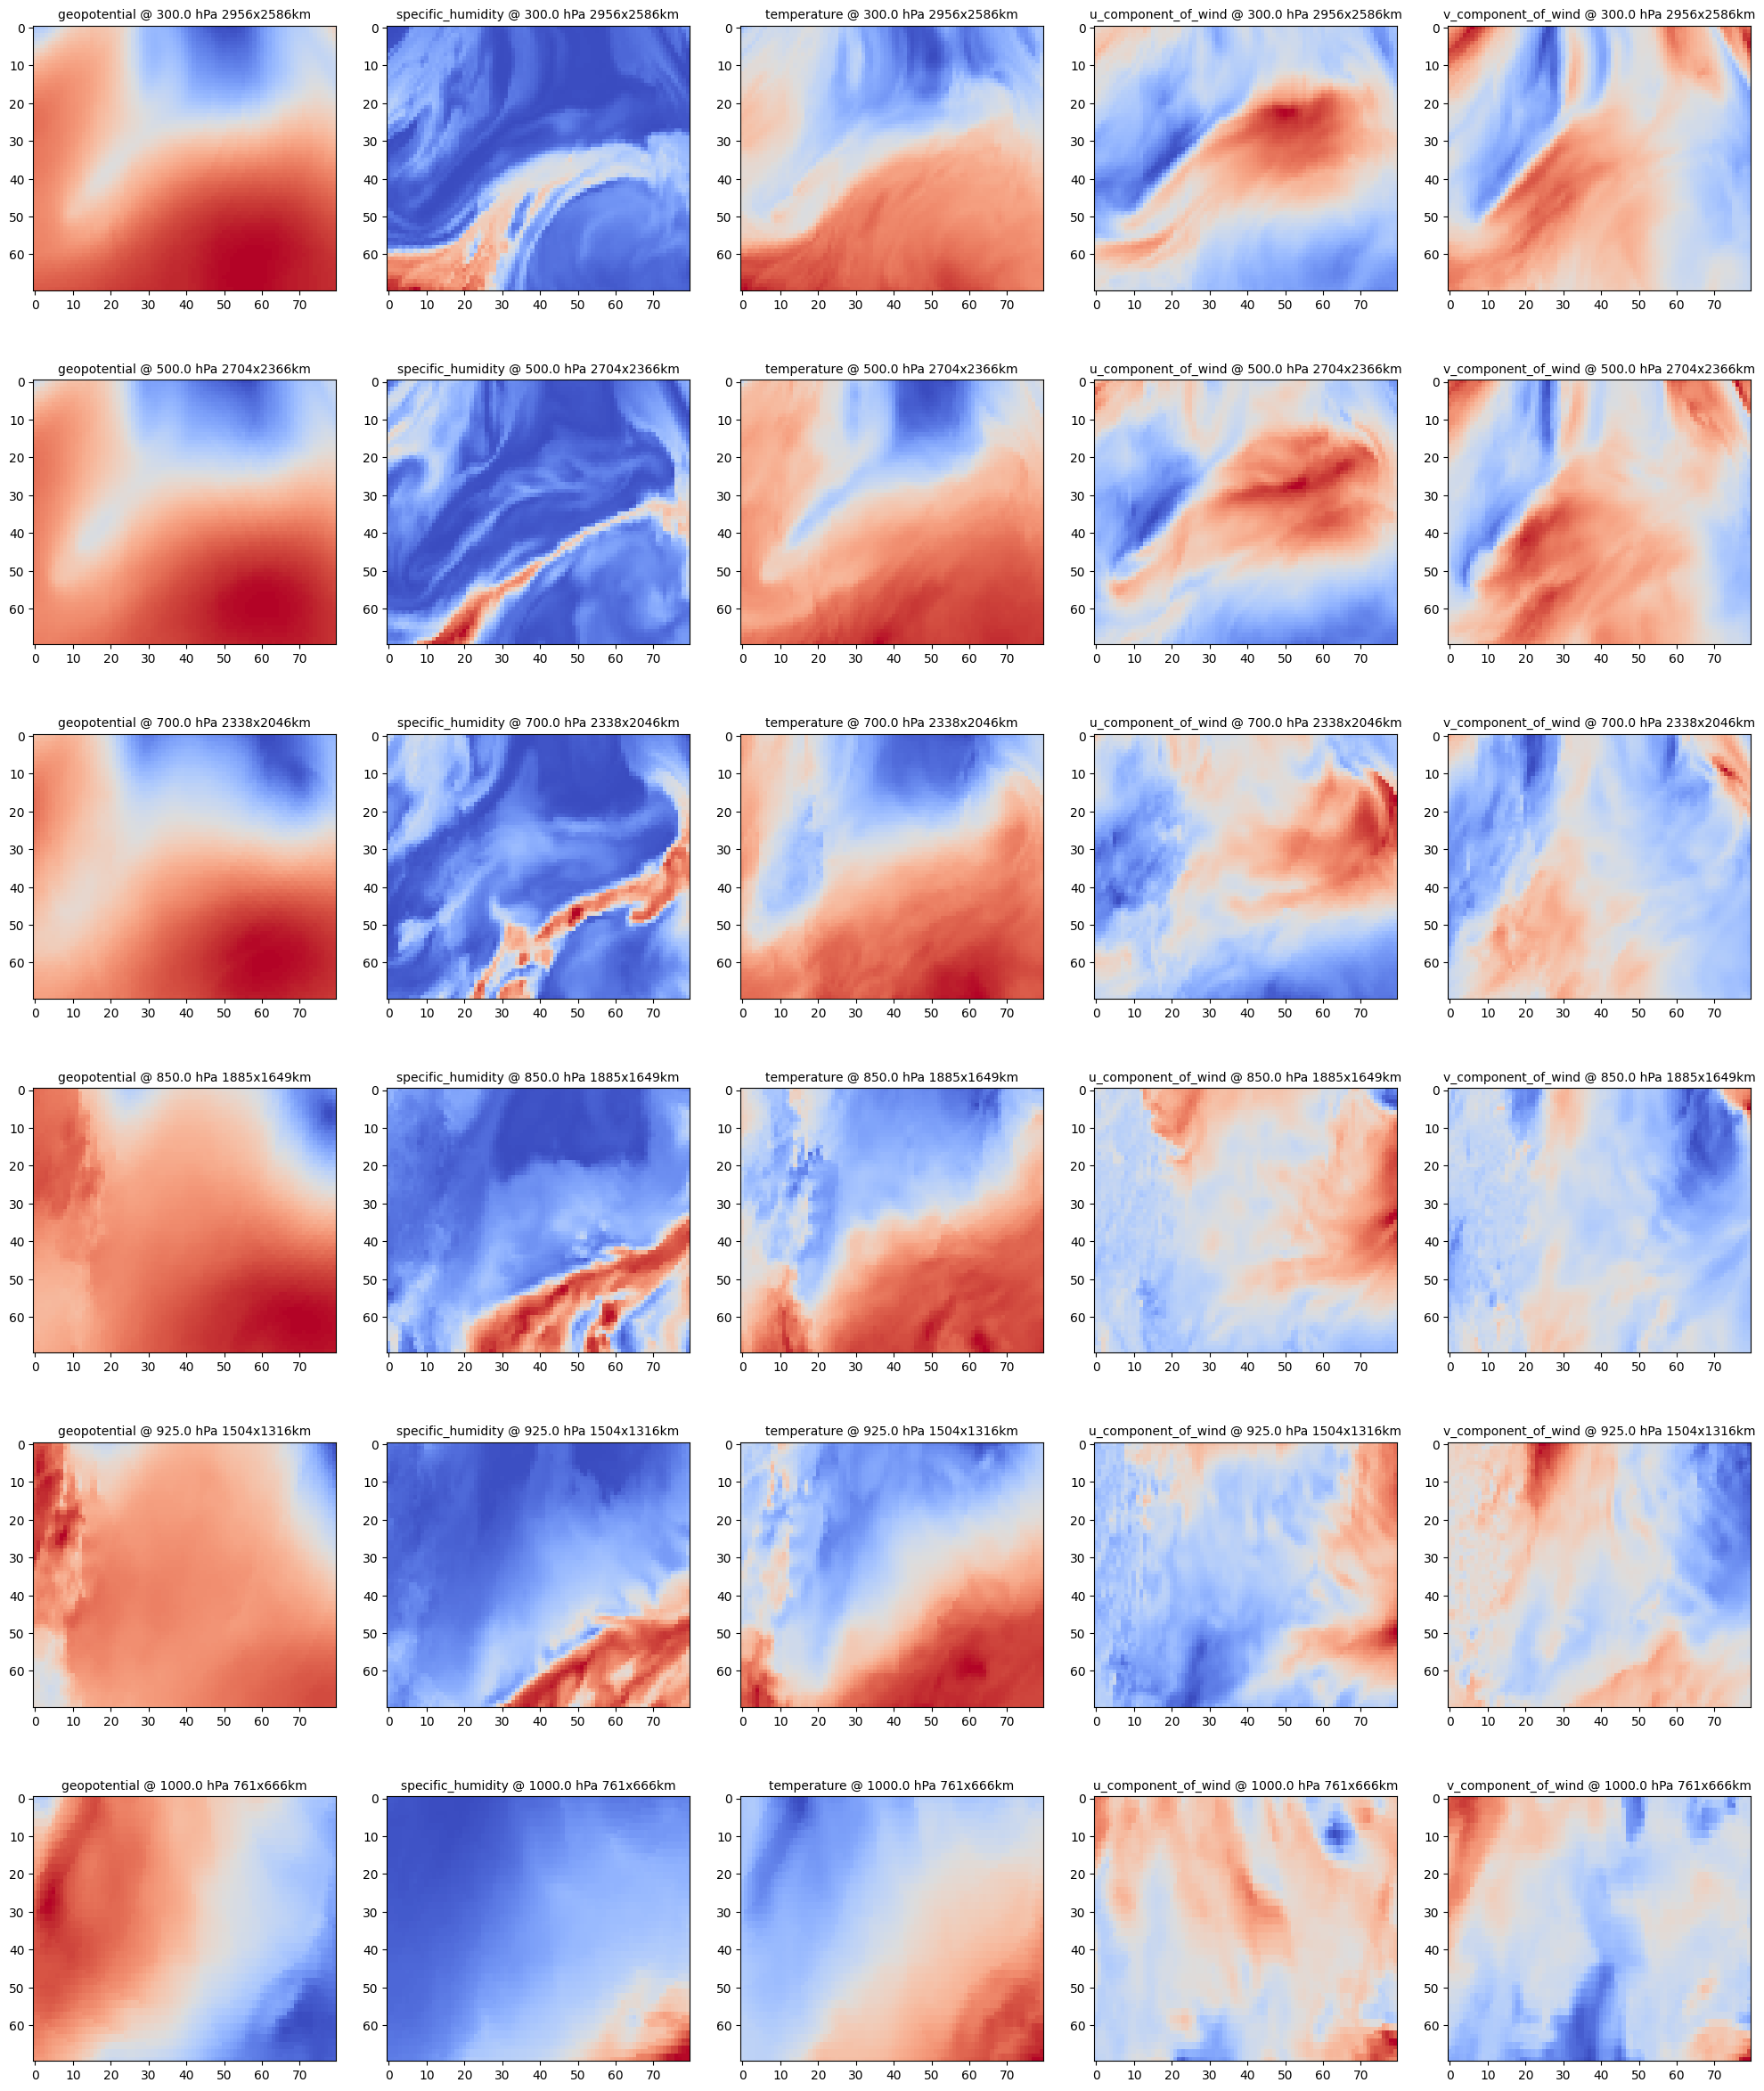

In [17]:
data_vars = era5_dvars
era5_levels = pressure_levels[1:]
e = np.abs(scale.to_numpy()[1:])
fig, axes = plt.subplots(len(era5_levels), len(era5_dvars), figsize=(4 * len(era5_dvars), 4 * len(era5_levels)))
fig.tight_layout()
axes = axes[::-1]
for i, level in enumerate(era5_levels):
    for j, dvar in enumerate(data_vars):
        ax = axes[i, j]
        assert isinstance(ax, plt.Axes)
        ax.imshow(arr[locate(dvar, level, 1)], cmap="coolwarm")
        ax.set_title(f"{dvar} @ {level} hPa {int(e[i,0])}x{int(e[i,-1])}km", fontsize=10)

In [14]:
import mesoscaler as ms

dsets = ms.DatasetSequence([urma, era5])
dsets

DatasetSequence(size=2)[
<xarray.DependentDataset>
Dimensions:               (Y: 1597, X: 2345, T: 2, Z: 1)
Coordinates:
    latitude              (Y, X) float64 19.23 19.23 19.24 ... 54.38 54.38 54.37
    longitude             (Y, X) float64 233.7 233.7 233.8 ... 300.9 300.9 301.0
  * time                  (T) datetime64[ns] 2019-01-02 2019-01-02T01:00:00
  * vertical              (Z) float64 1.013e+03
Dimensions without coordinates: Y, X, T, Z
Data variables:
    specific_humidity_2m  (T, Z, Y, X) float32 dask.array<chunksize=(1, 1, 1597, 2345), meta=np.ndarray>
    surface_pressure      (T, Z, Y, X) float32 dask.array<chunksize=(1, 1, 1597, 2345), meta=np.ndarray>
    temperature_2m        (T, Z, Y, X) float32 dask.array<chunksize=(1, 1, 1597, 2345), meta=np.ndarray>
    u_wind_component_10m  (T, Z, Y, X) float32 dask.array<chunksize=(1, 1, 1597, 2345), meta=np.ndarray>
    v_wind_component_10m  (T, Z, Y, X) float32 dask.array<chunksize=(1, 1, 1597, 2345), meta=np.ndarray>
Attributes:
    depends:  Dependencies(URMA)
<xarray.DependentDataset>
Dimensions:              (T: 2, Z: 37, Y: 721, X: 1440)
Coordinates:
    latitude             (Y, X) float32 90.0 90.0 90.0 ... -90.0 -90.0 -90.0
  * vertical             (Z) int64 1 2 3 5 7 10 20 ... 875 900 925 950 975 1000
    longitude            (Y, X) float32 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time                 (T) datetime64[ns] 2019-01-02 2019-01-02T01:00:00
Dimensions without coordinates: T, Z, Y, X
Data variables:
    geopotential         (T, Z, Y, X) float32 dask.array<chunksize=(1, 37, 721, 1440), meta=np.ndarray>
    specific_humidity    (T, Z, Y, X) float32 dask.array<chunksize=(1, 37, 721, 1440), meta=np.ndarray>
    temperature          (T, Z, Y, X) float32 dask.array<chunksize=(1, 37, 721, 1440), meta=np.ndarray>
    u_component_of_wind  (T, Z, Y, X) float32 dask.array<chunksize=(1, 37, 721, 1440), meta=np.ndarray>
    v_component_of_wind  (T, Z, Y, X) float32 dask.array<chunksize=(1, 37, 721, 1440), meta=np.ndarray>
Attributes:
    depends:  Dependencies(ERA5)
]

In [15]:
fitted = dsets.fit(scale)
resampler = scale.resample(fitted)
resampler

In [16]:
x = resampler(longitude, latitude, time=np.s_[start:stop])
x

AttributeError: 'slice' object has no attribute 'size'